In [10]:
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)
set.seed(6)

In [11]:
cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_data)<-c("age","sex","chest_pain","rest_bps","cholestrol_level","high_fbs?",
                            "rest_electrographics","max_heartrate","exercise_induced_angina","oldpeak","slope",
                            "colored_major_vessels","thal","risk_level")
                            #Note, generally 0=no issue and 1-4=problem
cleveland_data<-cleveland_data|>
                    mutate(exercise_induced_angina=case_when(exercise_induced_angina==0~"No",exercise_induced_angina==1~"Yes"))|>
                    mutate(sex=case_when(sex==0~"female",sex==1~"male"))
cleveland_data

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,rest_bps,cholestrol_level,high_fbs?,rest_electrographics,max_heartrate,exercise_induced_angina,oldpeak,slope,colored_major_vessels,thal,risk_level
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,male,4,160,286,0,2,108,Yes,1.5,2,3.0,3.0,2
67,male,4,120,229,0,2,129,Yes,2.6,2,2.0,7.0,1
37,male,3,130,250,0,0,187,No,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,male,4,130,131,0,0,115,Yes,1.2,2,1.0,7.0,3
57,female,2,130,236,0,2,174,No,0.0,2,1.0,3.0,1
38,male,3,138,175,0,0,173,No,0.0,1,?,3.0,0


[1] 149.606

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


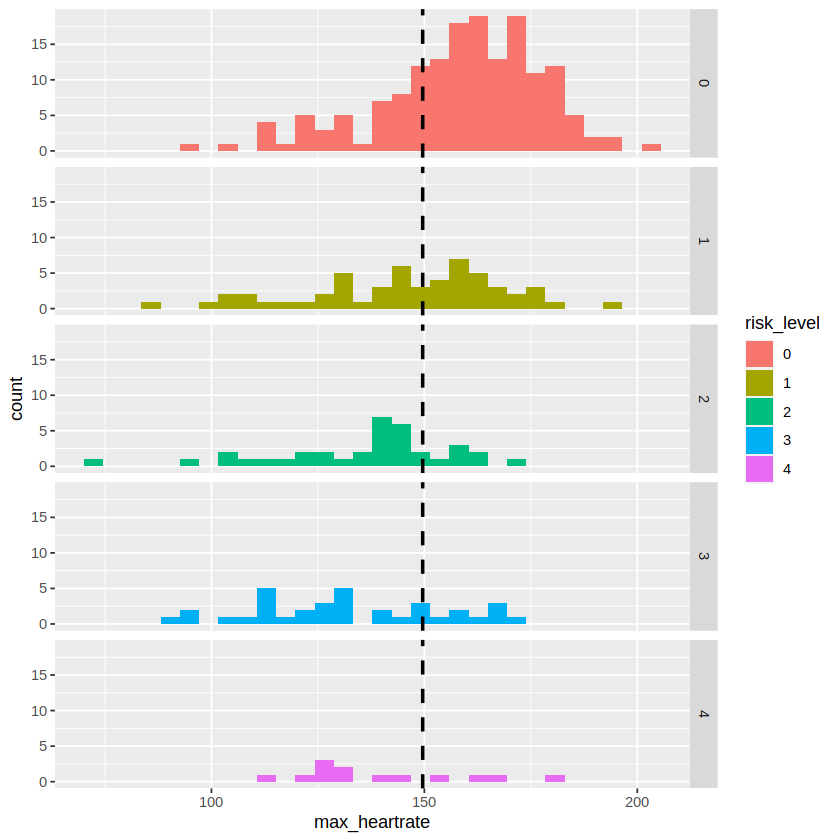

In [12]:
avg_heart_rate <- cleveland_data |>
                summarize(mean = mean(max_heartrate)) |>
                pull()

avg_heart_rate

angina_risk <- cleveland_data |>
            mutate(chest_pain = as_factor(chest_pain), risk_level = as_factor(risk_level))|>
            ggplot(aes(max_heartrate, fill = risk_level)) +
            geom_histogram() +
            facet_grid(rows = vars(risk_level)) +
            geom_vline(xintercept = avg_heart_rate, linetype = "dashed", size = 1.0)

angina_risk

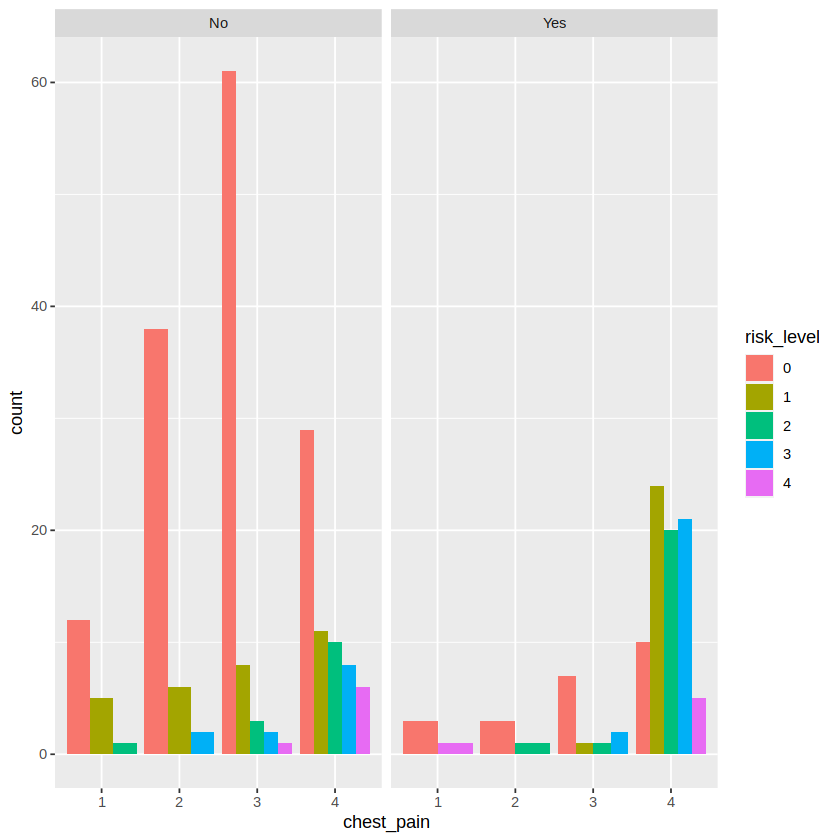

In [13]:
angina_risk_2 <- cleveland_data |>
            mutate(chest_pain = as_factor(chest_pain), risk_level = as_factor(risk_level))|>
            ggplot(aes(chest_pain, fill = risk_level)) +
            geom_bar(position="dodge") +
            facet_wrap(~exercise_induced_angina)

angina_risk_2

In [14]:
tabulated_cleveland <- cleveland_data |>
                    mutate(chest_pain = as_factor(chest_pain), risk_level = as_factor(risk_level))|>
                    group_by(chest_pain, exercise_induced_angina, risk_level) |>
                    summarize(count = n())

glimpse(tabulated_cleveland)

`summarise()` has grouped output by 'chest_pain', 'exercise_induced_angina'.
You can override using the `.groups` argument.


Rows: 29
Columns: 4
Groups: chest_pain, exercise_induced_angina [8]
$ chest_pain              <fct> 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3…
$ exercise_induced_angina <chr> "No", "No", "No", "Yes", "Yes", "No", "No", "N…
$ risk_level              <fct> 0, 1, 2, 0, 4, 0, 1, 3, 0, 2, 0, 1, 2, 3, 4, 0…
$ count                   <int> 12, 5, 1, 3, 1, 38, 6, 2, 3, 1, 61, 8, 3, 2, 1…


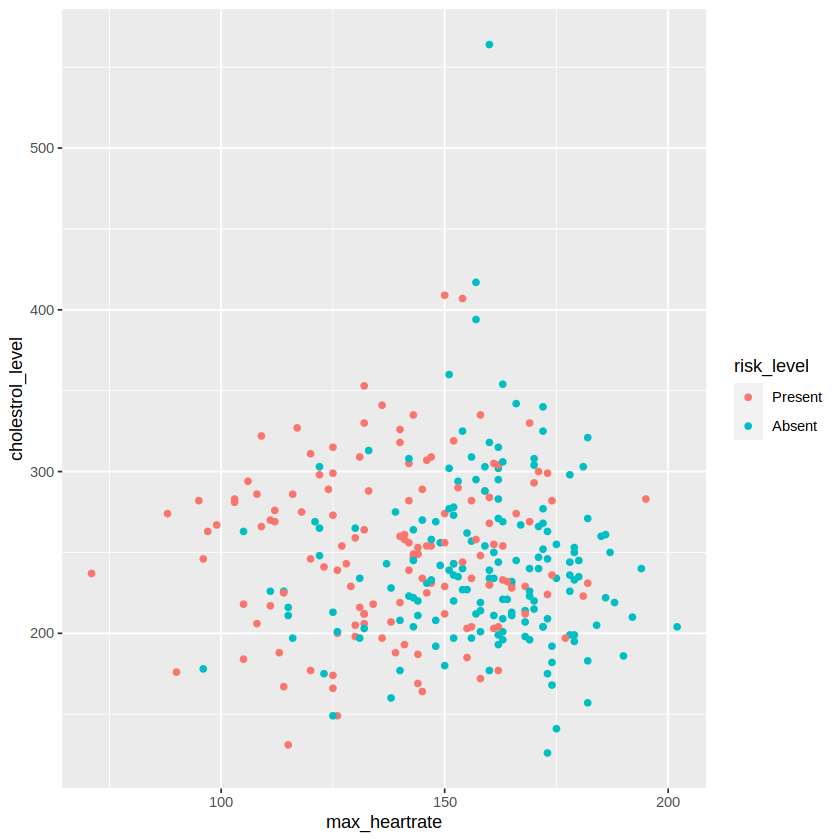

In [15]:
cleveland_data<-cleveland_data|>
                    mutate(risk_level=case_when(risk_level==0~"Absent",risk_level==1~"Present",
                                         risk_level==2~"Present",risk_level==3~"Present",risk_level==4~"Present"))

cholestrol_heartrate <- cleveland_data |>
                        mutate(risk_level = as_factor(risk_level), exercise_induced_angina = as_factor(exercise_induced_angina),
                               chest_pain = as_factor(chest_pain))|>
                        ggplot(aes(x = max_heartrate, y = cholestrol_level, color=risk_level)) +
                        geom_point()

cholestrol_heartrate

In [19]:
install.packages("kknn")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’




In [16]:
library(tidymodels)

In [17]:
heart_split <- initial_split(cleveland_data, prop = 0.75, strata = risk_level)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
heart_train
heart_test

age,sex,chest_pain,rest_bps,cholestrol_level,high_fbs?,rest_electrographics,max_heartrate,exercise_induced_angina,oldpeak,slope,colored_major_vessels,thal,risk_level
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
37,male,3,130,250,0,0,187,No,3.5,3,0.0,3.0,Absent
41,female,2,130,204,0,2,172,No,1.4,1,0.0,3.0,Absent
56,male,2,120,236,0,0,178,No,0.8,1,0.0,3.0,Absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,female,4,140,241,0,0,123,Yes,0.2,2,0.0,7.0,Present
45,male,1,110,264,0,0,132,No,1.2,2,0.0,7.0,Present
57,male,4,130,131,0,0,115,Yes,1.2,2,1.0,7.0,Present


age,sex,chest_pain,rest_bps,cholestrol_level,high_fbs?,rest_electrographics,max_heartrate,exercise_induced_angina,oldpeak,slope,colored_major_vessels,thal,risk_level
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
53,male,4,140,203,1,2,155,Yes,3.1,3,0.0,7.0,Present
57,male,3,150,168,0,0,174,No,1.6,1,0.0,3.0,Absent
50,female,3,120,219,0,0,158,No,1.6,2,0.0,3.0,Absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
63,female,4,124,197,0,0,136,Yes,0.0,2,0.0,3.0,Present
68,male,4,144,193,1,0,141,No,3.4,2,2.0,7.0,Present
57,female,2,130,236,0,2,174,No,0.0,2,1.0,3.0,Present


In [20]:
heart_recipe <- recipe(risk_level ~ cholestrol_level + max_heartrate, data = heart_train) |>
                step_normalize(all_predictors())
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3539823
Best kernel: rectangular
Best k: 3